In [1]:
from bitcoin import Bitcoin
from compiler import Compiler
from ethereum import EthereumWhitepaper, EthereumByzantium
from parallel import Parallel
from sm import SelfishMining, map_params, mappable_params
import fc16sapirshtein
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm
import traceback
import joblib
import random
import util

In [2]:
protocols = dict(
    bitcoin=Bitcoin(),
    parallel_2=Parallel(k=2),
    parallel_3=Parallel(k=3),
    eth_wp_2=EthereumWhitepaper(horizon=2),
    eth_bz_2=EthereumByzantium(horizon=2),
)

In [3]:
mdps = {
    k: Compiler(SelfishMining(v, maximum_size=8, **mappable_params)).mdp()
    for k, v in protocols.items()
}

for k, v in mdps.items():
    print(k, v)

bitcoin MDP of size 1652 / 4 / 7226 / 4.4
parallel_2 MDP of size 8258 / 8 / 36139 / 4.4
parallel_3 MDP of size 8807 / 9 / 36841 / 4.2
eth_wp_2 MDP of size 22918 / 6 / 82404 / 3.6
eth_bz_2 MDP of size 22862 / 6 / 82224 / 3.6


In [4]:
from dataclasses import replace

problems = dict(
    short_term_revenue=lambda t: replace(
        t, reward=t.effect.common_atk_reward, progress=t.effect.blocks_mined
    ),
    long_term_revenue=lambda t: replace(
        t, reward=t.effect.common_atk_reward, progress=t.effect.common_progress
    ),
    rewrite_length=lambda t: replace(
        t, reward=t.effect.defender_rewrite_length, progress=t.effect.blocks_mined
    ),
    rewrite_progress=lambda t: replace(
        t, reward=t.effect.defender_rewrite_progress, progress=t.effect.blocks_mined
    ),
    rewrite_l2=lambda t: replace(
        t,
        reward=1 if t.effect.defender_rewrite_length >= 2 else 0,
        progress=t.effect.blocks_mined,
    ),
)


def set_problem(mdp, map_transition):
    tab = []
    for actions in mdp.tab:
        new_actions = dict()
        for act, transitions in actions.items():
            new_transitions = []
            for t in transitions:
                new_transitions.append(map_transition(t))
            new_actions[act] = new_transitions
        tab.append(new_actions)
    new = replace(mdp, tab=tab)
    assert new.check()
    return new

In [5]:
def measure(*args, protocol, problem, horizon, eps, **kwargs):
    try:
        pmdp = set_problem(mdps[protocol], problems[problem])
        mmdp = map_params(pmdp, **kwargs)
        return util.optimize_and_evaluate(mmdp, horizon=horizon, eps=eps)
    except Exception as e:
        return dict(error=repr(e), traceback=traceback.format_exc())


def jobs():
    for a in [0.2, 0.3, 0.4]:
        for g in [0, 1]:
            for h in [100]:
                for e in [0.05, 0.025]:
                    for t in problems.keys():
                        for p in protocols.keys():
                            yield dict(
                                gamma=g,
                                alpha=a,
                                horizon=h,
                                eps=e,
                                problem=t,
                                protocol=p,
                            )


jobs = list(jobs())
jobs = random.sample(jobs, len(jobs))


def row(**kwargs):
    return kwargs | measure(**kwargs)


res_gen = joblib.Parallel(n_jobs=6, return_as="generator")(
    joblib.delayed(row)(**kwargs) for kwargs in jobs
)

rows = []
for res in tqdm.tqdm(res_gen, total=len(jobs)):
    rows.append(res)

data = pd.DataFrame(rows)

 26%|███████████████████████▏                                                                | 79/300 [03:20<08:09,  2.22s/it]/home/patrik/devel/cpr/_venv/lib64/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:293: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
 73%|███████████████████████████████████████████████████████████████▏                       | 218/300 [08:38<03:06,  2.27s/it]/home/patrik/devel/cpr/_venv/lib64/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:293: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████| 300/300 [11:24<00:00,  2.28s/it]


In [6]:
data = data.assign(rpp_minus_alpha=data.rpp - data.alpha)
data.columns

Index(['gamma', 'alpha', 'horizon', 'eps', 'problem', 'protocol',
       'vi_discount', 'vi_delta', 'vi_stop_delta', 'vi_iter', 'vi_max_iter',
       'vi_time', 'vi_max_value', 'ss_reachable', 'ss_nonzero', 'ss_time',
       'pe_iter', 'ptrev', 'rpp', 'time', 'vi_steady_value', 'error',
       'traceback', 'rpp_minus_alpha'],
      dtype='object')

In [7]:
data[data.error.notna()]

,gamma,alpha,horizon,eps,problem,protocol,vi_discount,vi_delta,vi_stop_delta,vi_iter,...,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value,error,traceback,rpp_minus_alpha
86,0,0.3,100,0.05,rewrite_length,parallel_3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AssertionError('something is off'),"Traceback (most recent call last):\n File ""/t...",NaN
236,0,0.2,100,0.05,rewrite_length,parallel_3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AssertionError('something is off'),"Traceback (most recent call last):\n File ""/t...",NaN


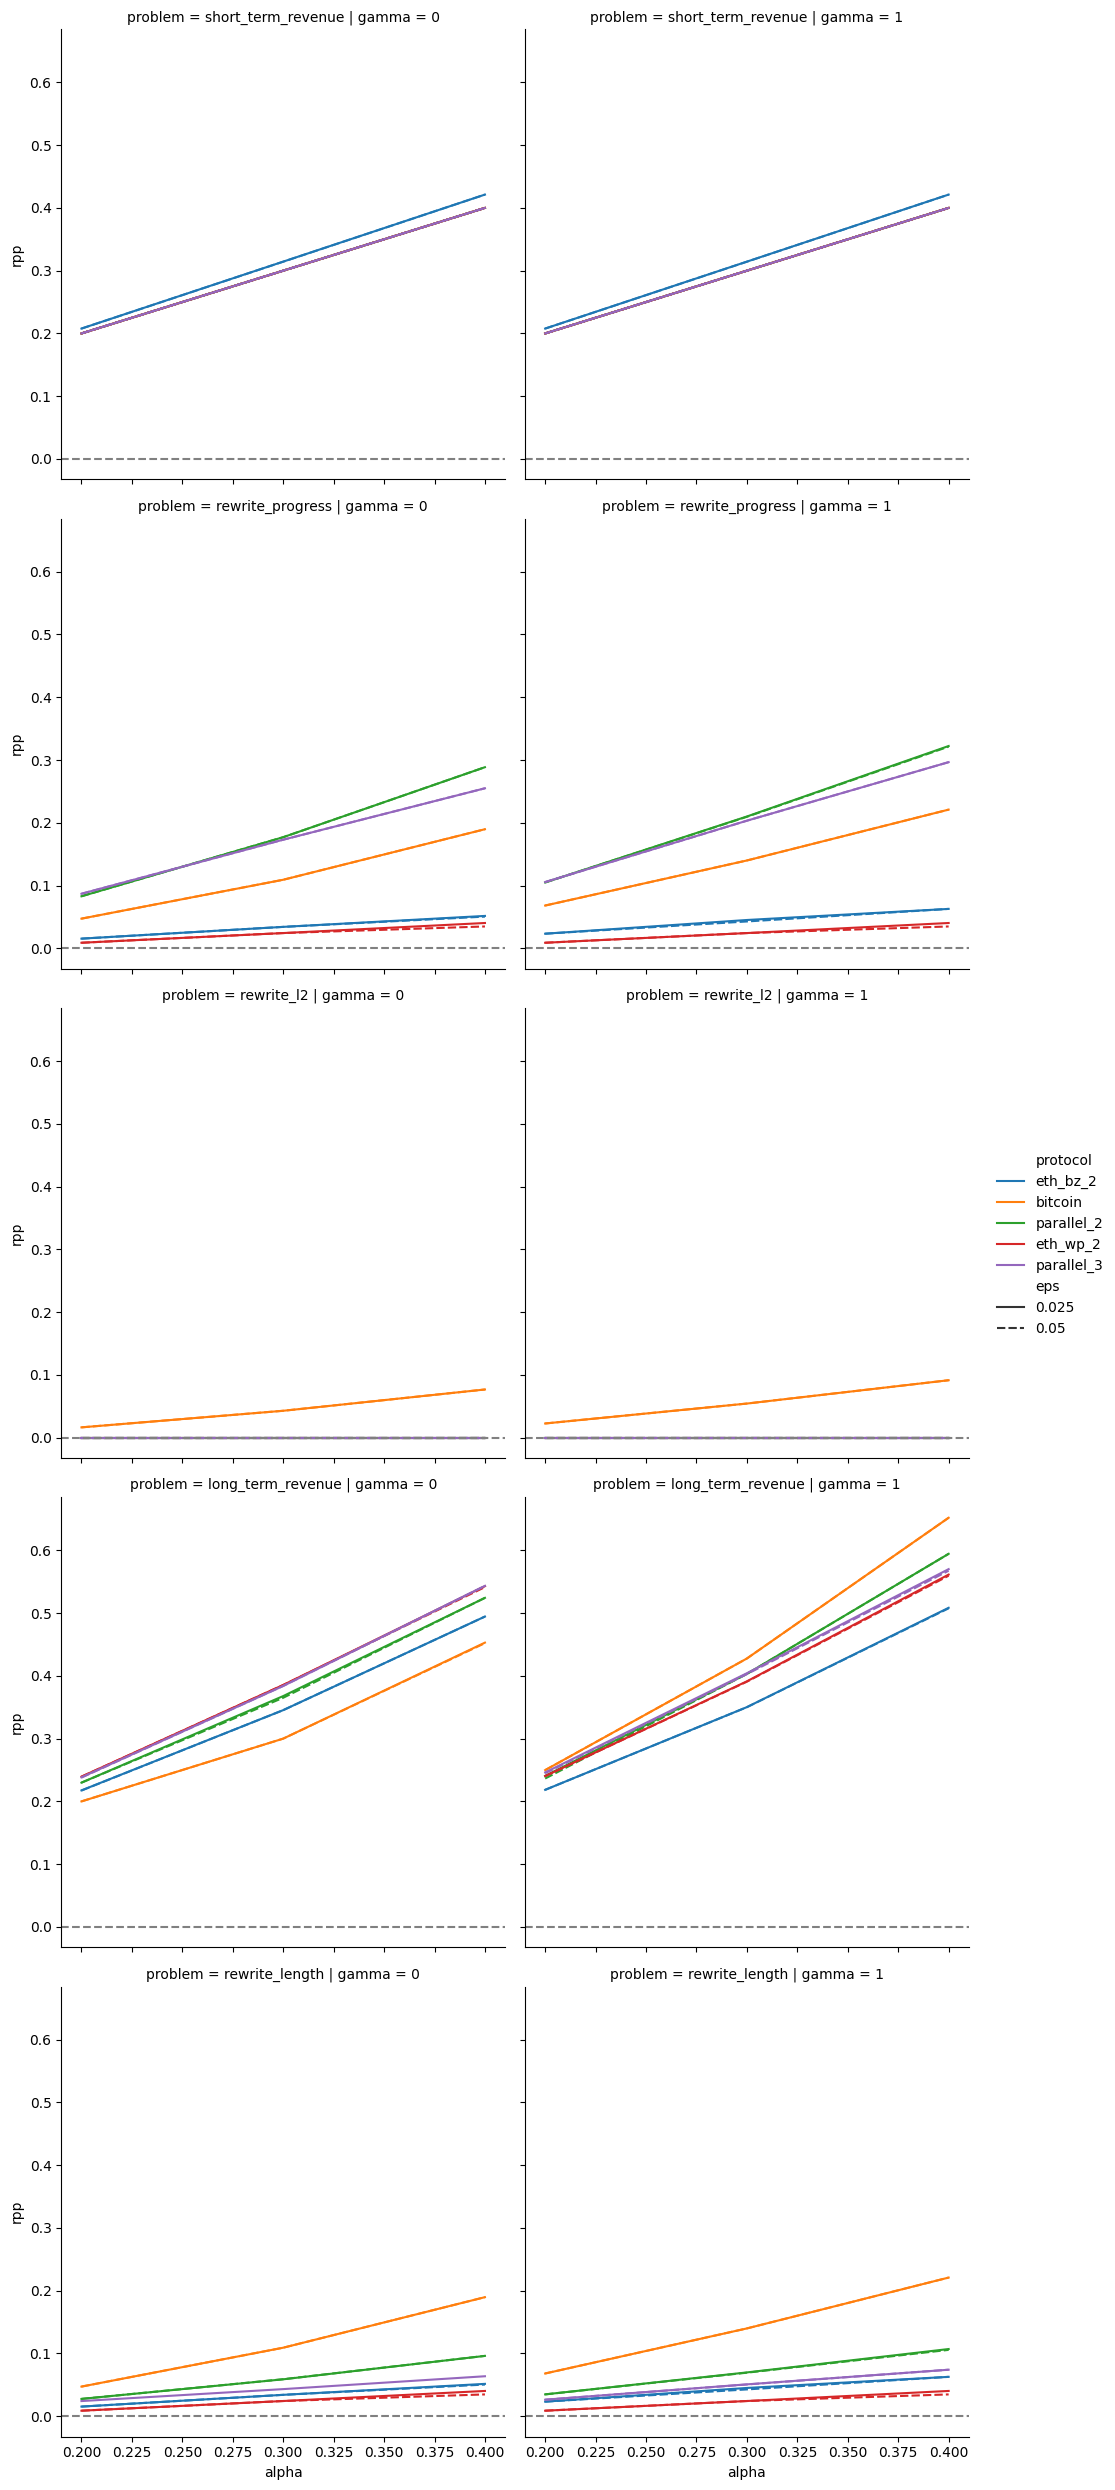

In [8]:
sns.relplot(
    data,
    kind="line",
    x="alpha",
    y="rpp",
    row="problem",
    col="gamma",
    hue="protocol",
    style="eps",
).refline(y=0)

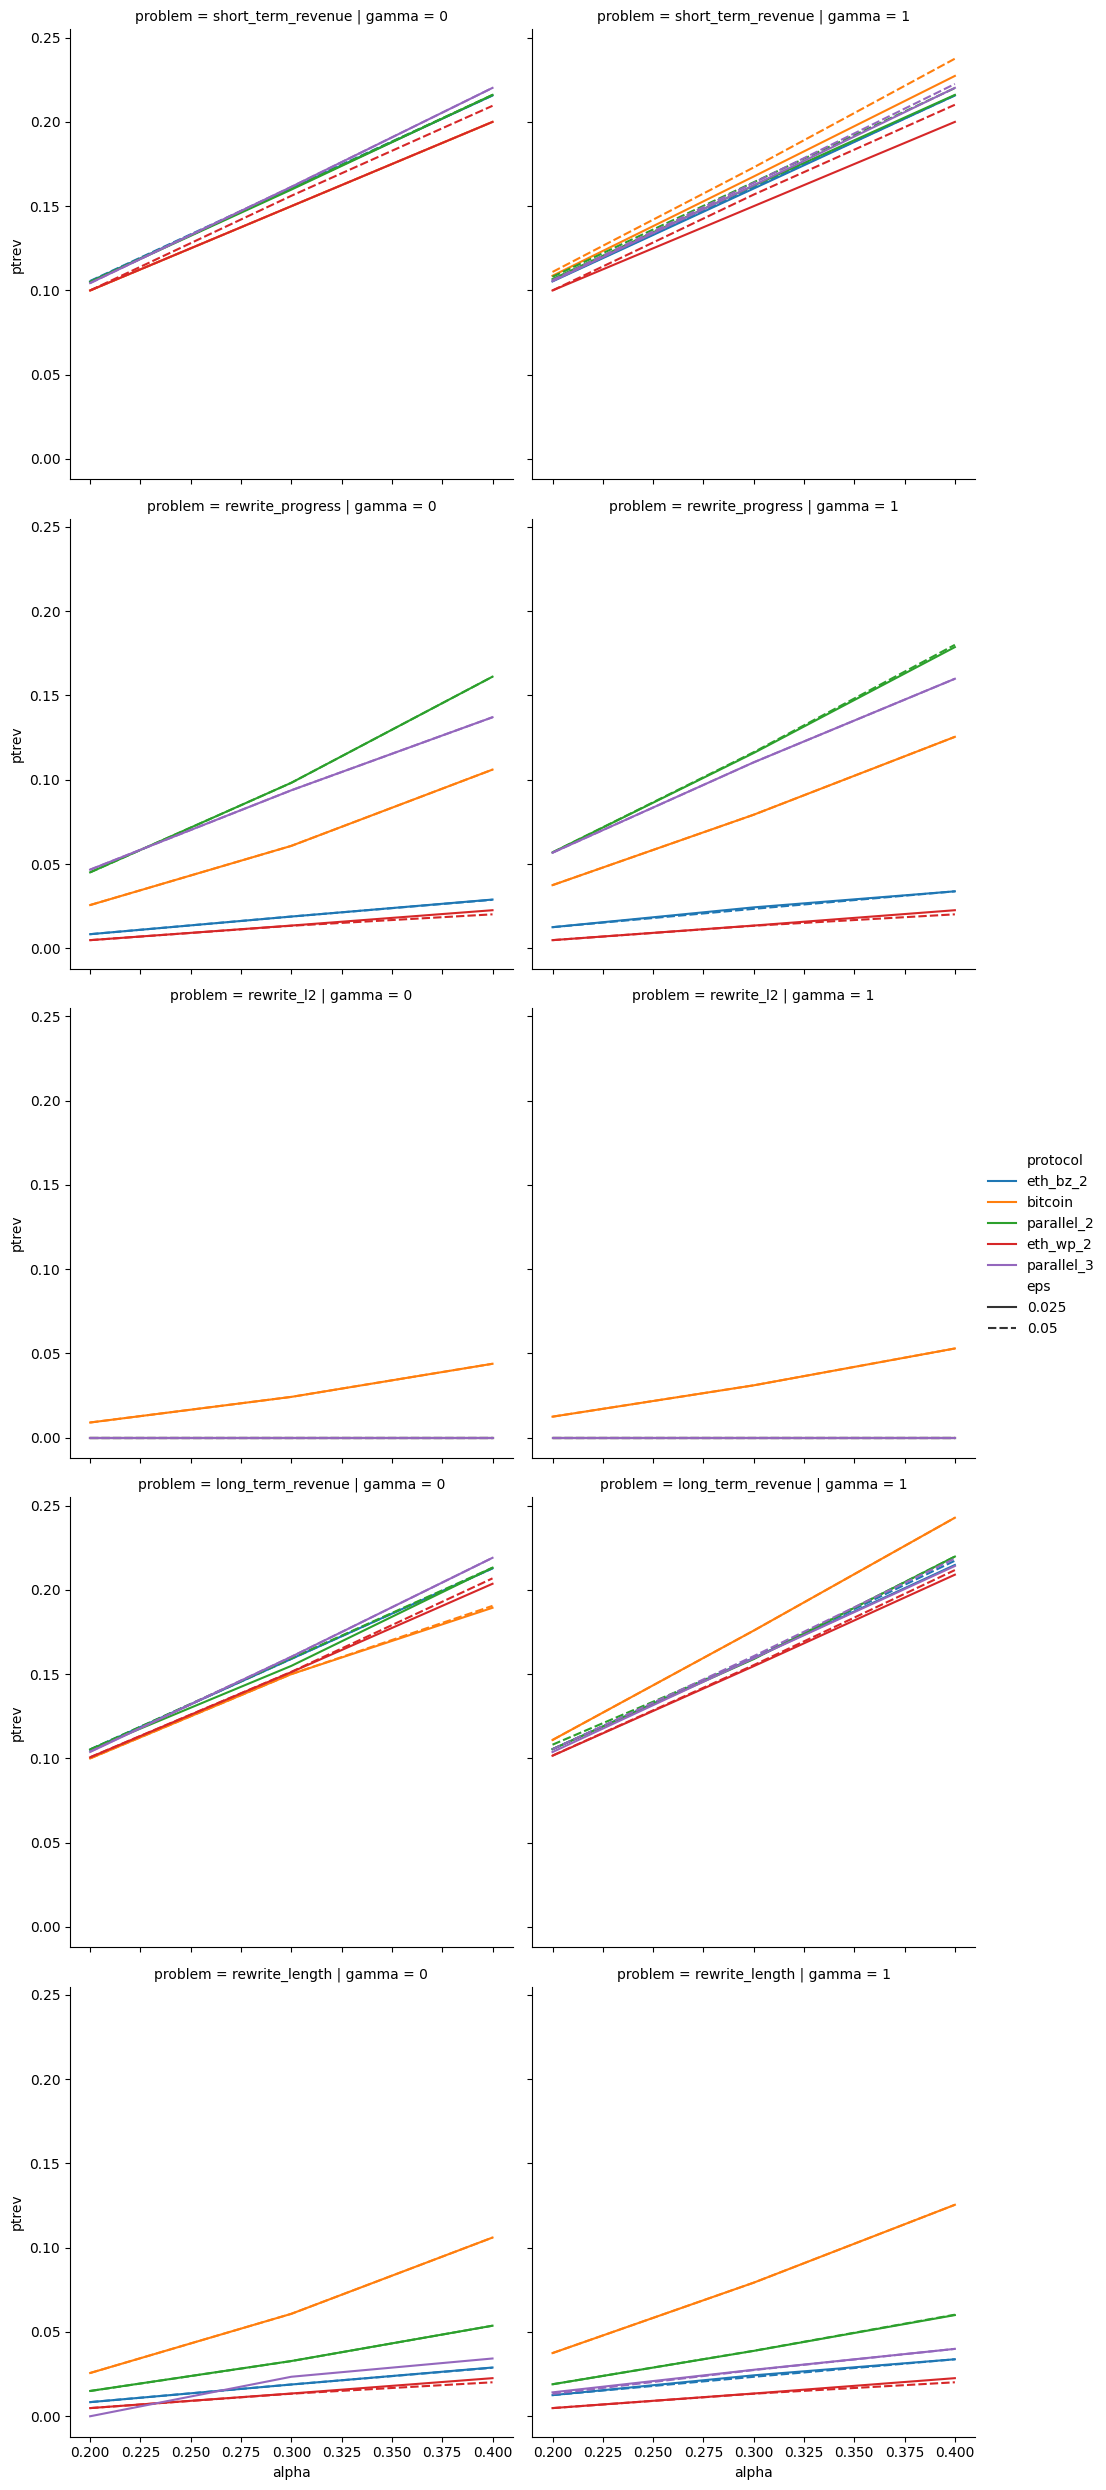

In [9]:
sns.relplot(
    data,
    kind="line",
    x="alpha",
    y="ptrev",
    row="problem",
    col="gamma",
    hue="protocol",
    style="eps",
)